# Gaussian Processes

 -Training set $X = (x_1,\dots,x_n)$ from a $d$-dimensional input distribution
 
 -Test set $X_\star = (x^\star_1,\dots,x^\star_m)$ from a $d$-dimensional input distribution
 
The Gaussian Process is a model under which the real-valued outputs $\mathbf{f} = (f_1,\dots,f_n)$ and $\mathbf{f}_\star = (f^\star_1,\dots,f^\star_m)$ associated to $X$ and $X_\star$ follow the Gaussian distribution:

\begin{equation*}
\left[
\begin{array}{c}\mathbf{f}\\
\mathbf{f}_\star\end{array}
\right]
\sim
\mathcal{N}
\left(
\left[
\begin{array}{c}
\boldsymbol{0}\\
\boldsymbol{0}
\end{array}
\right]
,
\left[
\begin{array}{cc}
\Sigma & \Sigma_\star\\
\Sigma_\star^\top & \Sigma_{\star\star}
\end{array}
\right]
\right)
\end{equation*}

where

\begin{align*}
\Sigma &= k(X,X)+\sigma^2 I\\
\Sigma_\star &= k(X,X_\star)\\
\Sigma_{\star\star} &= k(X_\star,X_\star)+\sigma^2 I
\end{align*}

 $k(\cdot,\cdot)$ is the Gaussian kernel function. **Predicting the output for new data points $X_\star$ is achieved by conditioning the joint probability distribution on the training set. Such conditional distribution called posterior distribution** can be written as:

\begin{equation}
\mathbf{f}_\star | \mathbf{f} \sim \mathcal{N} (
\underbrace{\Sigma_\star^\top \Sigma^{-1} \mathbf{f}}_{\boldsymbol{\mu}_\star}
~,~
\underbrace{\Sigma_{\star\star} - \Sigma_\star^\top \Sigma^{-1} \Sigma_\star}_{C_\star}
)
\end{equation}

Having inferred the posterior distribution, the log-likelihood of observing for the inputs $X_\star$ the outputs $\mathbf{y}_\star$ is given by evaluating the distribution $\mathbf{f}_\star | \mathbf{f}$ at $\mathbf{y}_\star$:

\begin{equation}
\log p(\mathbf{y}_\star | \mathbf{f}) = -\frac1{2} (\mathbf{y}_\star - \boldsymbol{\mu}_\star)^\top C^{-1}_\star (\mathbf{y}_\star - \boldsymbol{\mu}_\star) - \frac1{2}\log|C_\star| - \frac{m}{2}\log2\pi
\end{equation}

$|\cdot|$ determinant

In [7]:
import utils,datasets,numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class GP_Regressor:
    
    def __init__(self,Xtrain,Ytrain,width,noise):
        # Init. For the gaussin process : noise parameter, width and trianing data + outcome
        #Rappel : "self" appelle l'instance de la nouvelle classe. Les attributs ( variables ) sont définies dans l'instance d'initiation puis appelé au travers de l'instance de la classe (self.variable)
        
        self.width = width
        self.noise = noise
        
        self.Xtrain = Xtrain
        self.Ytrain = Ytrain
        
        self.kXX = utils.gaussianKernel(self.Xtrain,self.Xtrain,self.width) #Gaussian kernel using utils program
        
        self.SXX = self.kXX + (self.noise**2)*numpy.identity(len(self.Xtrain))
        self.SXXinv = numpy.linalg.inv(self.SXX)
        
        
    def predict(self,Xtest):
        # Takes as input the training data, returns a vector of the parameters of the conditionned distrubution, that is (f_star|f)
        # The parameters are (sigma_star, covmat_star)
        
        kXZ = utils.gaussianKernel(self.Xtrain,Xtest,self.width) # "Z" = Xtest = Xetoile
        kZZ = utils.gaussianKernel(Xtest,Xtest,self.width) # Pas besoin de ".self" car l'attribut n'est pas une instance de la classe mais un argument de la fonction
        
        
        SXZ = kXZ
        SZX = SXZ.T
        SZZ = kZZ + (self.noise**2)*numpy.identity(len(Xtest))
        
        mean = SZX.dot(self.SXXinv).dot(self.Ytrain)
        
        cov = SZZ - SZX.dot(self.SXXinv).dot(SXZ)
        
        return mean,cov 
        
        
    
    def loglikelihood(self,Xtest,Ytest):
        # For an input parameter of training data X_star, returns the log-likely hood of observing the y_star vector
        
        mean, cov = self.predict(Xtest)
        
        covinv = numpy.linalg.inv(cov)
        
        Q  = - 0.5 * covinv.dot(Ytest-mean).dot(Ytest-mean)
        R1 = - 0.5*numpy.linalg.slogdet(cov)[1] # numpy.linalg.slogdet  :  compute the sign and the logarithm of the natural determinant of an array
        R2 = - 0.5*len(Xtest)*numpy.log(2*numpy.pi)
        
        return Q + R1 + R2
    
    
    
    # What will me bplotted will be the mean and the variance for each test points ... In blue the mean prediction, in red the standard
    # deviation apegal the square vairanc of the data.
    
    # The training data are the green crosses
    # The test data used to evaluate the log likelihood are the green dots
    
    # Noise is reduced on the Y axis
        

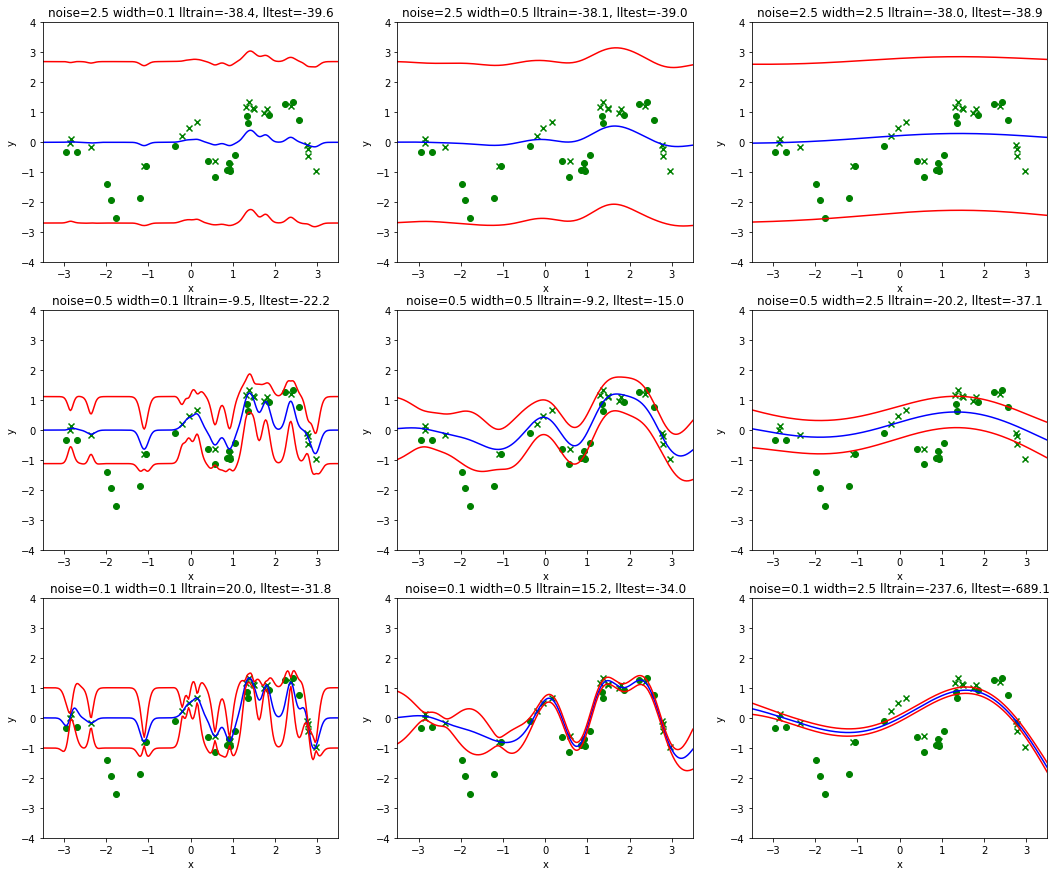

In [6]:
# Code given : visualization of the mean and variance of the predition at every location of the input space)
# Analyse of the different behaviors for different set of parameters sigma and width w

import numpy

# Open the toy data
Xtrain,Ytrain,Xtest,Ytest = utils.split(*datasets.toy())
# Create an analysis distribution
Xrange = numpy.arange(-3.5,3.51,0.025)[:,numpy.newaxis]

f = plt.figure(figsize=(18,15))

# Loop over several parameters:
for i,noise in enumerate([2.5,0.5,0.1]):
    for j,width in enumerate([0.1,0.5,2.5]):

        # Create Gaussian process regressor object
        gp = GP_Regressor(Xtrain,Ytrain,width,noise)
        
        # Compute the predicted mean and variance for test data
        mean,cov = gp.predict(Xrange)
        var = cov.diagonal()
        
        # Compute the log-likelihood of training and test data
        lltrain = gp.loglikelihood(Xtrain,Ytrain)
        lltest  = gp.loglikelihood(Xtest ,Ytest )
     
        # Plot the data
        p = f.add_subplot(3,3,3*i+j+1)
        p.set_title('noise=%.1f width=%.1f lltrain=%.1f, lltest=%.1f'%(noise,width,lltrain,lltest))
        p.set_xlabel('x')
        p.set_ylabel('y')
        p.scatter(Xtrain,Ytrain,color='green',marker='x') # training data
        p.scatter(Xtest,Ytest,color='green',marker='o')   # test data
        p.plot(Xrange,mean,color='blue')                  # GP mean
        p.plot(Xrange,mean+var**.5,color='red')           # GP mean + std
        p.plot(Xrange,mean-var**.5,color='red')           # GP mean - std
        p.set_xlim(-3.5,3.5)
        p.set_ylim(-4,4)

On remarque : 

- if we have too little noise, too much noise, the log likelihood performance drops (trying to keep it as low as possible) 
- if we have too little too big a sclae, the same can be observed

A fine choice of parameters is necessary for a good estimation via the loglikh. 


## Part 2: Application to the Yacht Hydrodynamics Data Set

Yacht Hydrodynamics Data Set http://archive.ics.uci.edu/ml/datasets/Yacht+Hydrodynamics
As stated on the web page, the input variables for this regression problem are:

1. Longitudinal position of the center of buoyancy
2. Prismatic coefficient
3. Length-displacement ratio
4. Beam-draught ratio
5. Length-beam ratio
6. Froude number

and we would like to predict from these variables the residuary resistance per unit weight of displacement (last column in the file `yacht_hydrodynamics.data`).

**Tasks:**

* **Load the data using `datasets.yacht()` and partition the data between training and test set using the function `utils.split()`. Standardize the data (center and rescale) so that each dimension of the training data and the labels have mean 0 and standard deviation 1 over the training set.**


* **Train several Gaussian processes on the regression task using various combinations of width and noise parameters.**


* **Draw two contour plots where the training and test log-likelihood are plotted as a function of the noise and width parameters. Choose suitable ranges of parameters so that the best parameter combination for the test set is in the plot. Use the same ranges and contour levels for the training and test plots. The contour levels can be chosen linearly spaced between e.g. 50 and the maximum log-likelihood value**

Noise params : 0.005 0.007 0.008 0.010 0.011 0.013 0.014 0.016 0.017 0.019 0.020 0.022 0.023 0.025 0.026 0.028 0.029 0.031 0.032 0.034 0.035 0.037 0.038 0.040
Width params : 0.050 0.135 0.220 0.304 0.389 0.474 0.559 0.643 0.728 0.813 0.898 0.983 1.067 1.152 1.237 1.322 1.407 1.491 1.576 1.661 1.746 1.830 1.915 2.000


<a list of 20 text.Text objects>

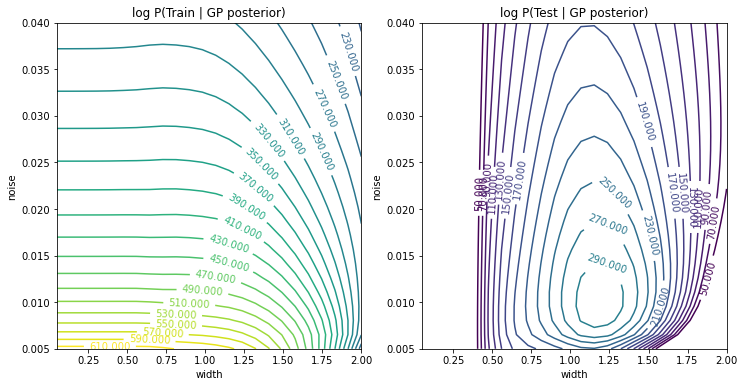

In [10]:
Xtrain, Ytrain, Xtest, Ytest = utils.split(*datasets.yacht()) #Load the data using "datasets.yacht()", kinda like calling a build in function directly

# Normalization of the Data : 

xmean, xstd = Xtrain.mean(axis=0), Xtrain.std(axis=0)
ymean, ystd = Ytrain.mean(), Ytrain.std()

Xtrain = (Xtrain - xmean) / xstd  # X training data normalized
Ytrain = (Ytrain - ymean) / ystd  # Y training data normalized

Xtest = (Xtest - xmean) / xstd    # X test data normalized
Ytest = (Ytest - ymean) / ystd    # Y test data normalized

noises = numpy.linspace(0.005, 0.04, num=24)
widths = numpy.linspace(0.05, 2.0, num=24)

PX, PY = numpy.meshgrid(widths,noises)  # Creation d'un plan avec widths et noises en axes 

PZ1 = numpy.zeros([len(noises),len(widths)])  # Creation d'un objet numpy rempli de zéro de dimension [.]
PZ2 = numpy.zeros([len(noises),len(widths)])

print('Noise params : %s'%" ".join(['%.3f'%n for n in noises]))
print('Width params : %s'%" ".join(['%.3f'%n for n in widths]))
# First part is simply formatted printing 
# .join() pour les string permet de simplement joindre les élements du tuple ou de la liste ensemble avec l'élement spécifié, peut être une liste
# Ici pour l'élément séparateur du join, on a une list implementation ... itération sur l'ensemble des paramètres

for i, noise in enumerate(noises): 
    for j, width in enumerate(widths):
        
        gp = GP_Regressor(Xtrain, Ytrain, width, noise)
        
        #On veut voir si il y a un effet "d'overfitting" avec le log likelikhood qui drop / augmente
        PZ1[i,j] = gp.loglikelihood(Xtrain, Ytrain)  # loglikelihood of training data
        PZ2[i,j] = gp.loglikelihood(Xtest, Ytest)  # loglikelihood of test data
        
# Plotting : 

f = plt.figure(figsize=(12,6))

m = 50
M = max(PZ1.max(),PZ2.max())

p = f.add_subplot(1,2,1)
p.set_title('log P(Train | GP posterior)')
p.set_xlabel('width')
p.set_ylabel('noise')
CS = p.contour(PX,PY,PZ1,levels=numpy.arange(m,M,20))
p.clabel(CS,inline=1,fontsize=10)
# Add label to the contours in CS, where contour set object returned by contour()

p = f.add_subplot(1,2,2)
p.set_title('log P(Test | GP posterior)')
p.set_xlabel('width')
p.set_ylabel('noise')
CS = p.contour(PX,PY,PZ2,levels=numpy.arange(m,M,20))
p.clabel(CS,inline=1,fontsize=10)

On voit clairement sur les contours plots, figure 1, que:  

- The higher the log likelikhood the better 
- the training data the more your reduce the noise and the smaller the scale (width) the more the likelikihood is (the number on the curve)

Sur le test : 

- 

In [8]:
datasets.yacht()

(array([[-2.3  ,  0.568,  4.78 ,  3.99 ,  3.17 ,  0.15 ],
        [-2.3  ,  0.568,  4.78 ,  3.99 ,  3.17 ,  0.175],
        [-2.3  ,  0.568,  4.78 ,  3.99 ,  3.17 ,  0.2  ],
        ...,
        [-2.3  ,  0.6  ,  4.34 ,  4.23 ,  2.73 ,  0.4  ],
        [-2.3  ,  0.6  ,  4.34 ,  4.23 ,  2.73 ,  0.425],
        [-2.3  ,  0.6  ,  4.34 ,  4.23 ,  2.73 ,  0.45 ]]),
 array([2.700e-01, 4.700e-01, 7.800e-01, 1.180e+00, 1.820e+00, 2.610e+00,
        3.760e+00, 4.990e+00, 7.160e+00, 1.193e+01, 2.011e+01, 3.275e+01,
        4.949e+01, 4.000e-02, 1.700e-01, 3.700e-01, 6.600e-01, 1.060e+00,
        1.590e+00, 2.330e+00, 3.290e+00, 4.610e+00, 7.110e+00, 1.199e+01,
        2.109e+01, 3.501e+01, 5.180e+01, 9.000e-02, 2.900e-01, 5.600e-01,
        8.600e-01, 1.310e+00, 1.990e+00, 2.940e+00, 4.210e+00, 5.540e+00,
        8.250e+00, 1.308e+01, 2.140e+01, 3.314e+01, 5.014e+01, 2.000e-01,
        3.500e-01, 6.500e-01, 9.300e-01, 1.370e+00, 1.970e+00, 2.830e+00,
        3.990e+00, 5.190e+00, 8.030e+00, 1.28